# Identifying Fraud From Enron Dataset

## Overview

Enron Scandal is one of the biggest financial scandals happened in the US which surfaced in 2001. It involves "a staff of executives that - by the use of accounting loopholes, special purpose entities, and poor financial reporting – were able to hide billions of dollars in debt from failed deals and projects" https://en.wikipedia.org/wiki/Enron_scandal. It eventually led to the bankruptcy of Enron corporation and 40$ billion lawsuit by shareholders. In this project we will use machine learning methods on a dataset coming from Enron from the time this scandal happened to find out who was involved in this fraud.

### Import statements

In [1]:
import sys
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
# from tester import dump_classifier_and_data

In [75]:
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from tester import dump_classifier_and_data
from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn import preprocessing


## Data Observations

### Summarize

>Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?  [relevant rubric items: “data exploration”, “outlier investigation”]

We will observe the data we have on hand. We have 146 entries and 21 rows of data. We will look further on the data and plot some of them to gain more insight.


In [6]:
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

In [7]:
data_dict

{'ALLEN PHILLIP K': {'bonus': 4175000,
  'deferral_payments': 2869717,
  'deferred_income': -3081055,
  'director_fees': 'NaN',
  'email_address': 'phillip.allen@enron.com',
  'exercised_stock_options': 1729541,
  'expenses': 13868,
  'from_messages': 2195,
  'from_poi_to_this_person': 47,
  'from_this_person_to_poi': 65,
  'loan_advances': 'NaN',
  'long_term_incentive': 304805,
  'other': 152,
  'poi': False,
  'restricted_stock': 126027,
  'restricted_stock_deferred': -126027,
  'salary': 201955,
  'shared_receipt_with_poi': 1407,
  'to_messages': 2902,
  'total_payments': 4484442,
  'total_stock_value': 1729541},
 'BADUM JAMES P': {'bonus': 'NaN',
  'deferral_payments': 178980,
  'deferred_income': 'NaN',
  'director_fees': 'NaN',
  'email_address': 'NaN',
  'exercised_stock_options': 257817,
  'expenses': 3486,
  'from_messages': 'NaN',
  'from_poi_to_this_person': 'NaN',
  'from_this_person_to_poi': 'NaN',
  'loan_advances': 'NaN',
  'long_term_incentive': 'NaN',
  'other': 'NaN'

Data observation is probably the most important part of any machine learning study. In this dataset we have lots of missing values, there should be a meaning way to handle these cases. Giving 0 for numerical values can sometimes be a solution to this problem but this doesnt always work. NaN can mean different things such as we dont know the value or there is no value, these two cases are quite different. Lets give an example, a NaN in salary field can mean, person X has a salary and we dont know the value, or it can mean this person is not getting paid by the company thus it is not an employee.

Lets check the people in the dataset first, there are 146 entries. But from the lectures we already know that the entry labeled as TOTAL has the total numbers so we need to get rid of this. So if we plot all of the entries we can clearly see, TOTAL is an outlier.

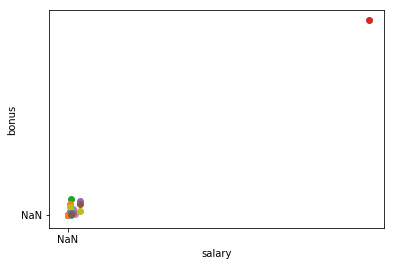

In [8]:
## Total in the dataset
for person in data_dict:
    X_point = data_dict[person]['salary']
    Y_point = data_dict[person]['bonus']
    plt.scatter(X_point, Y_point)

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

In [9]:
data_dict.pop('TOTAL', None);

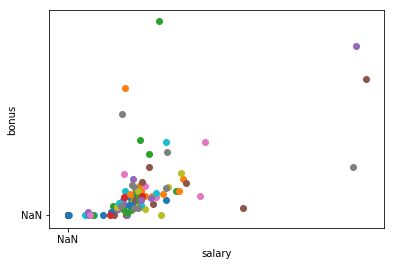

In [10]:
for person in data_dict:
    X_point = data_dict[person]['salary']
    Y_point = data_dict[person]['bonus']
    plt.scatter(X_point, Y_point)

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

### Outliers

Now we can do an outlier inspection, 4 dots can be clearly separated from the rest of the data points. Inspecting those we find that those are Skilling, Lay, Frevert, and Pickering. Two of them are the CEOs of Enron so we need them in the dataset, I am not touching them. There are other outliers for different rows of data, but detailed inspection shows nothing strange so I am not changing my dataset.

At this point we need to check to see the missing information for each person in the dataset.

In [11]:
missingValues = {}
for person in data_dict:
    n = 0
    for value in data_dict[person].items():
        if value[1] == 'NaN':
            n += 1
    missingValues[person] = n

In [12]:
missingValues

{'ALLEN PHILLIP K': 2,
 'BADUM JAMES P': 15,
 'BANNANTINE JAMES M': 5,
 'BAXTER JOHN C': 9,
 'BAY FRANKLIN R': 9,
 'BAZELIDES PHILIP J': 13,
 'BECK SALLY W': 7,
 'BELDEN TIMOTHY N': 4,
 'BELFER ROBERT': 14,
 'BERBERIAN DAVID': 13,
 'BERGSIEKER RICHARD P': 5,
 'BHATNAGAR SANJAY': 8,
 'BIBI PHILIPPE A': 5,
 'BLACHMAN JEREMY M': 5,
 'BLAKE JR. NORMAN P': 16,
 'BOWEN JR RAYMOND M': 5,
 'BROWN MICHAEL': 12,
 'BUCHANAN HAROLD G': 5,
 'BUTTS ROBERT H': 10,
 'BUY RICHARD B': 4,
 'CALGER CHRISTOPHER F': 5,
 'CARTER REBECCA C': 6,
 'CAUSEY RICHARD A': 5,
 'CHAN RONNIE': 16,
 'CHRISTODOULOU DIOMEDES': 16,
 'CLINE KENNETH W': 17,
 'COLWELL WESLEY': 5,
 'CORDES WILLIAM R': 11,
 'COX DAVID': 5,
 'CUMBERLAND MICHAEL S': 12,
 'DEFFNER JOSEPH M': 5,
 'DELAINEY DAVID W': 5,
 'DERRICK JR. JAMES V': 3,
 'DETMERING TIMOTHY J': 7,
 'DIETRICH JANET R': 5,
 'DIMICHELE RICHARD G': 10,
 'DODSON KEITH': 9,
 'DONAHUE JR JEFFREY M': 5,
 'DUNCAN JOHN H': 15,
 'DURAN WILLIAM D': 5,
 'ECHOLS JOHN B': 10,
 'ELLIOTT ST

Checking this, we notice some notice entity, The Travel Agency in the Park, so that is probably not a person. So I decided to remove that as well.

In [13]:
data_dict.pop('THE TRAVEL AGENCY IN THE PARK', None);

Lockhart Eugene has all its information missing so we can safely remove that as well.

In [14]:
data_dict.pop("LOCKHART EUGENE E", None);

At this step, I also decided to get rid of 3 more entities with 18 missing information, I was going to remove others as well but then I decided to stop here as missing information might be an indicator about the involvement as well. Again I dont have any idea about the missing data whether there is no data on hand or that data is not applicable to the person.

In [15]:
data_dict.pop('WHALEY DAVID A', None);
data_dict.pop('WROBEL BRUCE', None);
data_dict.pop('GRAMM WENDY L', None);

I am happy with the set of people I have on hand at this stage, but I need to do the same study for all the data in question to see if it can be used as a feature.

In [16]:
missingData = {}
for person in data_dict:
    for key, value in data_dict[person].items():
        if value == "NaN":
            if key in missingData:
                missingData[key] += 1
            else:
                missingData[key] = 1
missingData

{'bonus': 59,
 'deferral_payments': 102,
 'deferred_income': 92,
 'director_fees': 125,
 'email_address': 29,
 'exercised_stock_options': 41,
 'expenses': 46,
 'from_messages': 54,
 'from_poi_to_this_person': 54,
 'from_this_person_to_poi': 54,
 'loan_advances': 137,
 'long_term_incentive': 75,
 'other': 49,
 'restricted_stock': 31,
 'restricted_stock_deferred': 123,
 'salary': 46,
 'shared_receipt_with_poi': 54,
 'to_messages': 54,
 'total_payments': 18,
 'total_stock_value': 17}

We are missing a lot of data from loan advances and director fees but again missing information might mean something as well. Such as NaN in director fees might mean the person is not a director. So at this point I need to find a way to deal with NaN, since these are mainly numeric data I will replace with 0.  

In [17]:
fieldsToRemove = [
    "bonus",
    "deferral_payments",
    "deferred_income",
    "director_fees",
    "exercised_stock_options",
    "expenses",
    "loan_advances",
    "long_term_incentive",
    "other",
    "restricted_stock",
    "restricted_stock_deferred",
    "salary",   
    "total_payments",
    "total_stock_value"
]

for field in fieldsToRemove:
    for person in data_dict:
        if data_dict[person][field] == "NaN":
            data_dict[person][field] = 0


In [18]:
## Convert to Pandas DataFrame
dataPD = pd.DataFrame(data_dict)


In [19]:
## Transpose
dataPD2 = pd.DataFrame()
dataPD2 = dataPD.transpose()


In [17]:
# dataPD2.boxplot(column=['from_messages'])
df.boxplot(column='bonus')
dataPD2
# plt.boxplot(dataPD2)

NameError: name 'df' is not defined

## Features

>What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  [relevant rubric items: “create new features”, “intelligently select features”, “properly scale features”]
    
I will demonstrate my process in choosing the features I will use for my machine learning experiment. I will start with all the features to try first, then I will tweak my feature set to see the improvement.

### 1st Stage
My first feature set for the first stage;

In [20]:
feature1 = [
    "poi",
    "salary",
    "deferral_payments",
    "total_payments",
    "loan_advances",
    "bonus",
    "restricted_stock_deferred",
    "deferred_income",
    "total_stock_value",
    "expenses",
    "exercised_stock_options",
    "other",
    "long_term_incentive",
    "restricted_stock",
    "director_fees",
    "to_messages",
    "from_poi_to_this_person",
    "from_messages",
    "from_this_person_to_poi",
    "shared_receipt_with_poi"
]

I will test my classifiers by using the tester function. I will use Ada Boost, Naive Bayes, SVC(linear)

## Adaboost

In [21]:
adaBoostClass = AdaBoostClassifier()

In [22]:
import tester
tester.test_classifier(adaBoostClass, data_dict, feature1)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.83243	Precision: 0.38295	Recall: 0.28300	F1: 0.32547	F2: 0.29859
	Total predictions: 14000	True positives:  566	False positives:  912	False negatives: 1434	True negatives: 11088



## Naive Bayes

In [27]:
naiveBayesClass = GaussianNB()
tester.test_classifier(naiveBayesClass, data_dict, feature1)

GaussianNB(priors=None)
	Accuracy: 0.72014	Precision: 0.22171	Recall: 0.38200	F1: 0.28057	F2: 0.33374
	Total predictions: 14000	True positives:  764	False positives: 2682	False negatives: 1236	True negatives: 9318



## SVC

In [28]:
SVCClass = SVC(kernel='linear', max_iter=1000)
tester.test_classifier(SVCClass,data_dict, feature1)

/anaconda3/envs/udacityPy3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=1000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
	Accuracy: 0.49636	Precision: 0.14762	Recall: 0.52900	F1: 0.23083	F2: 0.34878
	Total predictions: 14000	True positives: 1058	False positives: 6109	False negatives:  942	True negatives: 5891



|               | Naive Bayes |SVC       |Ada Boost     |
|---------------|-------------|----------|----------|
| Accuracy      | 0.72        |0.49      |0.83     |
| Precision     | 0.22        |0.14      |0.38     |
| Recall        | 0.38        |0.52      |0.28     |

As one can guess without much 'engineering' on the features, algorithms I use are not very accurate, only Ada Boost is acceptable for accuracy.

### 2nd Stage

With the base results on hand lets tweak the feature set we use in the training. Some of the features are missing quite a bit of values thus it is not very helpfult to have them. I will remove loan_advances, restricted_stock_deferred, director_fees, and deferral_payments. This decision is just human intution, I havent yet tried K-best.

In [29]:
feature2 = [
    "poi",
    "salary",
    "total_payments",
    "bonus",
    "deferred_income",
    "total_stock_value",
    "expenses",
    "exercised_stock_options",
    "other",
    "long_term_incentive",
    "restricted_stock",
    "to_messages",
    "from_poi_to_this_person",
    "from_messages",
    "from_this_person_to_poi",
    "shared_receipt_with_poi"
]

## Ada Boost

In [30]:
tester.test_classifier(adaBoostClass, data_dict, feature2)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.83271	Precision: 0.38523	Recall: 0.28700	F1: 0.32894	F2: 0.30242
	Total predictions: 14000	True positives:  574	False positives:  916	False negatives: 1426	True negatives: 11084



## Naive Bayes

In [31]:
tester.test_classifier(naiveBayesClass, data_dict, feature2)

GaussianNB(priors=None)
	Accuracy: 0.82186	Precision: 0.34126	Recall: 0.26550	F1: 0.29865	F2: 0.27784
	Total predictions: 14000	True positives:  531	False positives: 1025	False negatives: 1469	True negatives: 10975



## SVC

In [32]:
tester.test_classifier(SVCClass,data_dict, feature2)

/anaconda3/envs/udacityPy3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=1000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
	Accuracy: 0.50900	Precision: 0.15763	Recall: 0.56100	F1: 0.24611	F2: 0.37108
	Total predictions: 14000	True positives: 1122	False positives: 5996	False negatives:  878	True negatives: 6004



|               | Naive Bayes |SVC       |Ada Boost     |
|---------------|-------------|----------|----------|
| Accuracy      | 0.82        |0.50      |0.83     |
| Precision     | 0.34        |0.15      |0.38     |
| Recall        | 0.26        |0.56      |0.28     |

In 2nd stage, with an easy change we see that accuracy of Naive Bayes algorithm increased 10 percent. This proves in class discussion of 'less might be more' in terms of features being used.

### 3rd Stage

In [33]:
def feat_eng(data_dict, feat1, feat2, newfeat):
    """
    Creates a new feature by using 2 existing features
    Args:
    data_dict: dictionary of data
    feat1: feature 1
    feat2: feature 2
    newfeat: new feature
    Output: dictionary of the new feature
    """
    for person in data_dict:
        if data_dict[person][feat2] == 0:
            data_dict[person][newfeat] = 0.0
        elif data_dict[person][feat1] == "NaN" or data_dict[person][feat2] == "NaN":
            data_dict[person][newfeat] = "NaN"
        else:
            data_dict[person][newfeat] = float(data_dict[person][feat1]) / float(data_dict[person][feat2])

    return data_dict

I will add new features that will identify better POIs in Enron.

**Financial**  
bonus_rate -> bonus / total payment  
salary_rate -> salary / total payment  
stock_rate -> total_stock_value / total payment

**Email**  
from_rate -> from_this_person_to_poi / from_messages  
to_rate -> from_poi_to_this_person / to messages


In [34]:
data_dict = feat_eng(data_dict,
                                      "bonus",
                                      "total_payments",
                                      "bonus_rate")

data_dict = feat_eng(data_dict,
                                      "salary",
                                      "total_payments",
                                      "salary_rate")

data_dict = feat_eng(data_dict,
                                      "total_stock_value",
                                      "total_payments",
                                      "stock_rate")

data_dict = feat_eng(data_dict,
                                      "from_this_person_to_poi",
                                      "from_messages",
                                      "from_rate")

data_dict = feat_eng(data_dict,
                                      "from_poi_to_this_person",
                                      "to_messages",
                                      "to_rate")

In [35]:
feature3 = [
    "poi",
    "salary",
    "deferral_payments",
    "total_payments",
    "loan_advances",
    "bonus",
    "restricted_stock_deferred",
    "deferred_income",
    "total_stock_value",
    "expenses",
    "exercised_stock_options",
    "other",
    "long_term_incentive",
    "restricted_stock",
    "director_fees",
    "to_messages",
    "from_poi_to_this_person",
    "from_messages",
    "from_this_person_to_poi",
    "shared_receipt_with_poi",
    "bonus_rate",
    "salary_rate",
    "stock_rate",
    "from_rate",
    "to_rate"
]

## Ada Boost

In [89]:
tester.test_classifier(adaBoostClass, data_dict, feature3)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.83729	Precision: 0.40466	Recall: 0.29500	F1: 0.34124	F2: 0.31191
	Total predictions: 14000	True positives:  590	False positives:  868	False negatives: 1410	True negatives: 11132



## Naive Bayes

In [37]:
tester.test_classifier(naiveBayesClass, data_dict, feature3)

GaussianNB(priors=None)
	Accuracy: 0.70250	Precision: 0.21920	Recall: 0.42250	F1: 0.28864	F2: 0.35639
	Total predictions: 14000	True positives:  845	False positives: 3010	False negatives: 1155	True negatives: 8990



## SVC

In [38]:
tester.test_classifier(SVCClass,data_dict, feature3)

/anaconda3/envs/udacityPy3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=1000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
	Accuracy: 0.49636	Precision: 0.14772	Recall: 0.52950	F1: 0.23100	F2: 0.34907
	Total predictions: 14000	True positives: 1059	False positives: 6110	False negatives:  941	True negatives: 5890



|               | Naive Bayes |SVC       |Ada Boost     |
|---------------|-------------|----------|----------|
| Accuracy      | 0.70        |0.49      |0.84     |
| Precision     | 0.21        |0.14      |0.40     |
| Recall        | 0.42        |0.52      |0.29     |

We havent seen much change, in this stage, but with Ada Boost, we are almost in the acceptable levels. It is surprising to see SVC is quite bad in accuracy. My guess here we need to play with the parameters to get better performance which I will leave it to the last stage.

## 4th Stage - K-best

In [39]:
def kbest(data_dict, features_list):
    """
    Selects the best features
    Args:
    data_dict: dictionary of data
    features: list of features 
    Output: dictionary of the new feature
    """
    data = featureFormat(data_dict, features_list, sort_keys=True)
    # Split labels (poi) from other features
    targets, features = targetFeatureSplit(data)

    # Set up the scaler
    minmax_scaler = preprocessing.MinMaxScaler()
    features_minmax = minmax_scaler.fit_transform(features)

    # k is selected 10 --
    k_best = SelectKBest(chi2, k=10)

    # Use the instance to extract the k best features
    features_kbest = k_best.fit_transform(features_minmax, targets)

    scores = ['%.2f' % elem for elem in k_best.scores_]

    # Round the values
    feature_scores_pvalues = ['%.3f' % elem for elem in k_best.pvalues_]

    # Create an array of feature names, scores and pvalues
    k_features = [(features_list[i+1],
                   scores[i],
                   feature_scores_pvalues[i]) for i in k_best.get_support(indices=True)]

    # Sort the array by score
    k_features = sorted(k_features, key=lambda f: float(f[1]))
    print (k_features)


    return

In [40]:
kbest(data_dict, feature1)

[('director_fees', '1.41', '0.235'), ('other', '1.64', '0.200'), ('shared_receipt_with_poi', '2.28', '0.131'), ('long_term_incentive', '2.42', '0.120'), ('total_payments', '2.69', '0.101'), ('salary', '2.86', '0.091'), ('bonus', '4.90', '0.027'), ('total_stock_value', '5.28', '0.022'), ('loan_advances', '6.53', '0.011'), ('exercised_stock_options', '6.61', '0.010')]


We got the list of best features to use, so we create our feature list like in our previous trials.

In [41]:
featuresKBest = [
    "poi",
    "director_fees",
    "other",
    "shared_receipt_with_poi",
    "long_term_incentive",
    "total_payments",
    "salary",
    "bonus",
    "total_stock_value",
    "loan_advances",
    "exercised_stock_options"
]

## Ada Boost

In [42]:
tester.test_classifier(adaBoostClass, data_dict, featuresKBest)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.82129	Precision: 0.29888	Recall: 0.18650	F1: 0.22968	F2: 0.20167
	Total predictions: 14000	True positives:  373	False positives:  875	False negatives: 1627	True negatives: 11125



## Naive Bayes

In [43]:
tester.test_classifier(naiveBayesClass, data_dict, featuresKBest)

GaussianNB(priors=None)
	Accuracy: 0.76064	Precision: 0.20694	Recall: 0.23850	F1: 0.22160	F2: 0.23144
	Total predictions: 14000	True positives:  477	False positives: 1828	False negatives: 1523	True negatives: 10172



## SVC

In [44]:
tester.test_classifier(SVCClass,data_dict, featuresKBest)

/anaconda3/envs/udacityPy3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=1000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
	Accuracy: 0.50757	Precision: 0.15241	Recall: 0.53650	F1: 0.23739	F2: 0.35672
	Total predictions: 14000	True positives: 1073	False positives: 5967	False negatives:  927	True negatives: 6033



|               | Ada Boost    | Naive Bayes  |SVC          |
|---------------|--------------|--------------|-------------|
| Accuracy      | 0.82         |  0.76        |0.50         |
| Precision     | 0.29         |  0.20        |0.15         |
| Recall        | 0.18         |  0.23        |0.53         |

Again this step didnt change the situation much, we even saw some fall in Ada Boost. So we should continue.

## 5th Stage - Feature Scaling

We should use feature scaling to increase the accuracy, as mentioned in documentation of StandartScaler object in scikit. 
http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

> For instance many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the L1 and L2 regularizers of linear models) assume that all features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

More info is on this paper; https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf

Examples were in this website, http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [86]:
def feature_scalars(d, features_list, test_size, random_state=42):
    """
    Gives every feature a scalar
    """
    data = featureFormat(d, features_list, sort_keys=True)
    # Split between labels (poi) and the rest of features
    target, features = targetFeatureSplit(data)

    # Create both training and test sets through split_data()
    features_train, features_test, labels_train, labels_test = train_test_split(
        features,
        target,
        test_size=test_size,
        random_state=random_state)
        
    classifier = ["ADA", "SVC"]
    for c in classifier:
        if c == "ADA":
            clf = AdaBoostClassifier()
        elif c == "SVM":
            clf = SVC(kernel='linear', max_iter=1000)

        result = []
        clf.fit(features_train, labels_train)
        pred = clf.predict(features_test)
        importances = clf.feature_importances_

        for i in range(len(importances)):
            t = [features_list[i], importances[i]]
            result.append(t)

        result = sorted(result, key=lambda x: x[1], reverse=True)

        print (result)


    return None

In [87]:
feature_scalars(data_dict, feature3, 0.35)

[['total_stock_value', 0.20000000000000001], ['expenses', 0.12], ['poi', 0.10000000000000001], ['loan_advances', 0.10000000000000001], ['exercised_stock_options', 0.080000000000000002], ['deferral_payments', 0.059999999999999998], ['from_this_person_to_poi', 0.059999999999999998], ['salary_rate', 0.059999999999999998], ['stock_rate', 0.059999999999999998], ['long_term_incentive', 0.040000000000000001], ['bonus_rate', 0.040000000000000001], ['restricted_stock_deferred', 0.02], ['deferred_income', 0.02], ['other', 0.02], ['shared_receipt_with_poi', 0.02], ['salary', 0.0], ['total_payments', 0.0], ['bonus', 0.0], ['restricted_stock', 0.0], ['director_fees', 0.0], ['to_messages', 0.0], ['from_poi_to_this_person', 0.0], ['from_messages', 0.0], ['from_rate', 0.0]]
[['total_stock_value', 0.20000000000000001], ['expenses', 0.12], ['poi', 0.10000000000000001], ['loan_advances', 0.10000000000000001], ['exercised_stock_options', 0.080000000000000002], ['deferral_payments', 0.059999999999999998], 

In [48]:
feature4SVC = [
    "poi",
    "salary",
    "deferral_payments",
    "loan_advances",
    "restricted_stock_deferred",
    "total_stock_value",
    "exercised_stock_options",
    "other",
    "long_term_incentive",
    "director_fees",
    "to_messages",
    "from_poi_to_this_person",
    "from_messages",
    "from_this_person_to_poi",
    "shared_receipt_with_poi",
    "bonus_rate",
    "salary_rate",
    "stock_rate",
    "from_rate",
    "to_rate"
]

In [47]:
clf_SVC = SVC(kernel='linear', max_iter=1000)
tester.test_classifier(clf_SVC, data_dict, feature4SVC)

/anaconda3/envs/udacityPy3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=1000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
	Accuracy: 0.39936	Precision: 0.12769	Recall: 0.54950	F1: 0.20722	F2: 0.33088
	Total predictions: 14000	True positives: 1099	False positives: 7508	False negatives:  901	True negatives: 4492



This step, I didnt apply on Naive Bayes as it doesnt have features_importances_ value. Now in the last two stages I am more focussed on SVC, as I am guessing parameter flexibility of SVM will give me better results this stage. So the results this stage for SVC is, Accuracy ==> 39.93%  Precision ==> 12.76% and Recall ==>54.95%

## Last Stage - Tuning


At this stage I am going to fine tune parameters of SVC algorithm. For this, GridSearchCV and Pipeline will be used. Tuning parameters should greatly increases the accuracy of a model, but there is always the danger of overfitting. To avoid this we need to always train and test the model, to get a benchmark of how well is the model doing. 

In [49]:
def tune_SVC(d, features_list, scaler=True):
    """
    Prints the results of tuning process.
    """
    # Strip the values
    data = featureFormat(d, features_list, sort_keys=True)
    # Split between labels (poi) and the rest of features
    labels, features = targetFeatureSplit(data)

    svm = Pipeline([('scaler', StandardScaler()), ('svm', SVC())])

    parameters = ([{'svm__C': [1, 50, 100, 1000],
                    'svm__gamma': [0.5, 0.1, 0.01],
                    'svm__degree': [1, 2],
                    'svm__kernel': ['rbf', 'poly', 'linear'],
                    'svm__max_iter': [1, 100, 1000]}])

    svm_clf = GridSearchCV(svm,
                           parameters,
                           scoring='f1').fit(
                           features, labels).best_estimator_
    
    warnings.filterwarnings('ignore', 'Solver terminated early.*')
    tester.test_classifier(svm_clf, d, features_list)

    return None

In [50]:
import warnings
warnings.filterwarnings('ignore')

tune_SVC(data_dict, feature4SVC)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm', SVC(C=50, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma=0.1, kernel='poly',
  max_iter=100, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
	Accuracy: 0.80336	Precision: 0.32545	Recall: 0.35100	F1: 0.33774	F2: 0.34557
	Total predictions: 14000	True positives:  702	False positives: 1455	False negatives: 1298	True negatives: 10545



>What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?  [relevant rubric item: “pick an algorithm”]

>What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? What parameters did you tune? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).  [relevant rubric items: “discuss parameter tuning”, “tune the algorithm”]

After running GridSearchCV, scikit optimized parameters for best accuracy in SVM. Unlike my trials best kernel happens to be poly, and other parameters are like this; SVC(C=50, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma=0.1, kernel='poly',
  max_iter=100, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
  
So with this step, now our models is much more accurate;
Accuracy==> 80.3%   Precision ==>32.5%  and Recall==>35%

These results are quite good, thus this will be my last model.

As I mentioned earlier a 'very much' tuned algorithm can be overfitting the data so a data scientist should alway check with some other data to ensure, the model works. So when I validate the results with different numbers of sets they are;

 METRICS FOR TEST SIZE OF: 0.2
* Accuracy: 0.785714285714
* Precision: 0.333333333333
* R0ecall: 0.2


 METRICS FOR TEST SIZE OF: 0.4
* Accuracy: 0.839285714286
* Precision: 0.6
* R0ecall: 0.3


 METRICS FOR TEST SIZE OF: 0.6
* Accuracy: 0.821428571429
* Precision: 0.4375
* R0ecall: 0.538461538462




In [88]:
def get_svc(d, features_list):
    """
    Generates the classifier for final submission.
    """
    # Keep only the values from features_list
    data = featureFormat(d, features_list, sort_keys=True)
    # Split between labels (poi) and the rest of features
    labels, features = targetFeatureSplit(data)

    svm = Pipeline([('scaler', StandardScaler()), ('svm', SVC())])

    parameters = ([{'svm__C': [50],
                    'svm__gamma': [0.1],
                    'svm__degree': [2],
                    'svm__kernel': ['poly'],
                    'svm__max_iter': [100]}])

    svm_clf = GridSearchCV(svm,
                           parameters,
                           scoring='f1').fit(
                           features, labels).best_estimator_

    return svm_clf

In [62]:
my_clf = get_svc(data_dict, feature4SVC)
my_dataset = data_dict
my_features = feature4SVC

dump_classifier_and_data(my_clf, my_dataset, my_features)

test_clf(data_dict, feature4SVC, random_state=42)

# METRICS FOR TEST SIZE OF: 0.2
* Accuracy: 0.785714285714
* Precision: 0.333333333333
* R0ecall: 0.2


# METRICS FOR TEST SIZE OF: 0.4
* Accuracy: 0.839285714286
* Precision: 0.6
* R0ecall: 0.3


# METRICS FOR TEST SIZE OF: 0.6
* Accuracy: 0.821428571429
* Precision: 0.4375
* R0ecall: 0.538461538462




In [61]:
def test_clf(d, features_list, random_state=42):
    """
    Returns test results
    """
    # Keep only the values from features_list
    data = featureFormat(d, features_list, sort_keys=True)
    # Split between labels (poi) and the rest of features
    labels, features = targetFeatureSplit(data)

    test_sizes = [0.2, 0.4, 0.6]

    for test_size in test_sizes:
        # Create both training and test sets through split_data()
        features_train, features_test, labels_train, labels_test = train_test_split(
            features,
            labels,
            test_size=test_size,
            random_state=random_state)

        clf = get_svc(d, features_list)

        clf.fit(features_train, labels_train)
        pred = clf.predict(features_test)

        print ("# METRICS FOR TEST SIZE OF:", test_size)
        acc = accuracy_score(labels_test, pred)
        print ("* Accuracy:", acc)

        pre = precision_score(labels_test, pred)
        print ("* Precision:", pre)

        rec = recall_score(labels_test, pred)
        print ("* Recall:", rec)
        print ("\n")

    return

## Conclusion


>What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?  [relevant rubric items: “discuss validation”, “validation strategy”]

>Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]


After ensuring that I am not overfitting my model, I can safely assume I have a good model that can estimate POI in Enron.

In my model I mainly used 3 metrics, accuracy, recall and Precision.

#### Accuracy

Accuracy is the ratio of the model finding the right person associated with the label. Although it is the main metric I checked, and I wanted at least around 80 percent to call it a good model. Accuracy can be misleading in skewed populations, meaning there is a big difference in numbers of labels. 


#### Recall

Is the ratio of correctly identified labels, in the population of objects picked by the model as labels. For example, number of correctly identified POI within the group of all entities labelled by POI by the model(correctly or incorrectly). So looking at our metric almost one third of the POI is actually POI.


#### Precision

Precision is the ratio of chances of someone being actually POI if it is labelled as POI, so it is like the level of certainity within the subset of labelled entities.


This was a very hard assignment which took months of work and I wathced every lecture at least twice. And there were so many possibilities or options to do this work. But because of time constraints and me being a noob in the area gave me this work. Some of the codes parts I checked from the web, as there are many scikit examples online. The only dissapointment was I wasnt very succesful in using DataFrames in scikit. Also there was some time observations I have made such as Ada being very slow and SVC being quite efficient. So I am also happy about the results in terms of efficiency.

## Resources

http://scikit-learn.org/stable/auto_examples/plot_compare_reduction.html#sphx-glr-auto-examples-plot-compare-reduction-py

http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html


https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/